# Transformers for solving Audio Captchas

## Transformers

    1. https://github.com/facebookresearch/fairseq/blob/main/examples/wav2vec/README.md
    2. https://huggingface.co/docs/transformers/model_doc/wav2vec2



In [42]:
%%capture --no-display
# Packages
! pip3 install wave
! pip3 install numpy
! pip3 install matplotlib
! pip3 install pydub

In [29]:
# This is what BotDetect sounds like
!afplay ../data/botdetect/hb5ew.wav

Duration (s):  3.66
Sample Rate:  8000


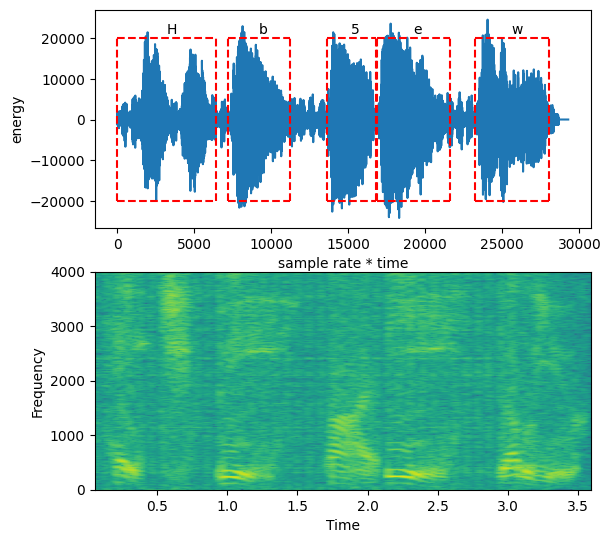

In [102]:
# Get data generated
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment

audio = AudioSegment.from_file('../data/botdetect/hb5ew.wav')
samples = audio.get_array_of_samples()
sample_rate = audio.frame_rate
duration = audio.duration_seconds
print('Duration (s): ', duration)
print('Sample Rate: ', sample_rate)

# Visualise
plt.figure(1)

plot_a = plt.subplot(211)
plot_a.plot(samples)
plot_a.set_xlabel('sample rate * time')
plot_a.set_ylabel('energy')

# Boxes for letters and numbers
# H
plot_a.vlines(0 * 8000, -20000, 20000, linestyles ="dashed", colors ="r")
plot_a.vlines(0.8 * 8000, -20000, 20000, linestyles ="dashed", colors ="r")
plot_a.hlines(20000, 0 * 8000, 0.8 * 8000, linestyles ="dashed", colors ="r")
plot_a.hlines(-20000, 0 * 8000, 0.8 * 8000, linestyles ="dashed", colors ="r")
plot_a.text(((0.8-0) / 2 + 0) * 8000, 21000, 'H')
# b
plot_a.vlines(0.9 * 8000, -20000, 20000, linestyles ="dashed", colors ="r")
plot_a.vlines(1.4 * 8000, -20000, 20000, linestyles ="dashed", colors ="r")
plot_a.hlines(20000, 0.9 * 8000, 1.4 * 8000, linestyles ="dashed", colors ="r")
plot_a.hlines(-20000, 0.9 * 8000, 1.4 * 8000, linestyles ="dashed", colors ="r")
plot_a.text(((1.4-0.9) / 2 + 0.9) * 8000, 21000, 'b')
# 5
plot_a.vlines(1.7 * 8000, -20000, 20000, linestyles ="dashed", colors ="r")
plot_a.vlines(2.1 * 8000, -20000, 20000, linestyles ="dashed", colors ="r")
plot_a.hlines(20000, 1.7 * 8000, 2.1 * 8000, linestyles ="dashed", colors ="r")
plot_a.hlines(-20000, 1.7 * 8000, 2.1 * 8000, linestyles ="dashed", colors ="r")
plot_a.text(((2.1-1.7) / 2 + 1.7) * 8000, 21000, '5')
# e
plot_a.vlines(2.11 * 8000, -20000, 20000, linestyles ="dashed", colors ="r")
plot_a.vlines(2.7 * 8000, -20000, 20000, linestyles ="dashed", colors ="r")
plot_a.hlines(20000, 2.11 * 8000, 2.7 * 8000, linestyles ="dashed", colors ="r")
plot_a.hlines(-20000, 2.11 * 8000, 2.7 * 8000, linestyles ="dashed", colors ="r")
plot_a.text(((2.11-2.7) / 2 + 2.7) * 8000, 21000, 'e')
# w
plot_a.vlines(2.9 * 8000, -20000, 20000, linestyles ="dashed", colors ="r")
plot_a.vlines(3.5 * 8000, -20000, 20000, linestyles ="dashed", colors ="r")
plot_a.hlines(20000, 2.9 * 8000, 3.5 * 8000, linestyles ="dashed", colors ="r")
plot_a.hlines(-20000, 2.9 * 8000, 3.5 * 8000, linestyles ="dashed", colors ="r")
plot_a.text(((3.5-2.9) / 2 + 2.9) * 8000, 21000, 'w')

plot_b = plt.subplot(212)
plot_b.specgram(samples, NFFT=1024, Fs=sample_rate, noverlap=900)
plot_b.set_xlabel('Time')
plot_b.set_ylabel('Frequency')

plt.subplots_adjust(bottom=0.1, top=1.1)
plt.show()

The above shows that different letters have different signatures depending on the number of syllables. For instance the letter "H" can look like 2 letters but is really "hay-ch".
Preprocessing of Audio Signals, may allow for removing inbetween data that does not correspond to a letter or number. 
